## HLCA core, assessment of study-dataset splitting

In this notebook we will determine which of the studies that have substantial differences in experimental conditions within study will need to be split into separate datasets (datasets will be the "batches" used for integration).

### Import modules

In [89]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

sys.path.append("../../scripts/")
import preprocessing
import utils

For pretty coding and automatic script loading after script changes, not needed to run notebook:

In [2]:
%load_ext lab_black

In [3]:
%load_ext autoreload
%autoreload 2

### Set paths:

In [8]:
# path of partly preprocessed HLCA file used in this notebook:
path_HLCA_subjfilt_ann = "../../data/HLCA_core_h5ads/HLCA_v1_intermediates/LCA_Bano_Barb_Jain_Kras_Lafy_Meye_Mish_MishBud_Nawi_Seib_Teic_RAW_subjfilt_ann.h5ad"
# path to results directory:
dir_out = "../../results/study_splitting_into_datasets"

### Check batch effects:

load HLCA:

In [4]:
adata_full = sc.read(path_HLCA_subjfilt_ann)

Set study we want to look at. For the HLCA core, we checked "Banovich_Kropski_2020", "Jain_Misharin_2021", "Lafyatis_Rojas_2019" and "Seibold_2020".

In [5]:
study_of_interest = "Banovich_Kropski_2020"

for banovich kropski study, we also want to look at processing site:

In [6]:
if study_of_interest == "Banovich_Kropski_2020":
    include_processing_site = True
else:
    include_processing_site = False
    

subset to study:

In [105]:
adata = adata_full[adata_full.obs.study == study_of_interest, :].copy()

annotate with QC info and normalize (simple total counts normalization):

In [106]:
adata = preprocessing.add_cell_annotations(adata, var_index="gene_ids")

In [108]:
median_libsize = np.median(adata.X.sum(axis=1).flatten(), axis=1)

In [109]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=median_libsize[0, 0])

perform pca:

In [110]:
sc.tl.pca(adata)

In [114]:
n_pcs = 50

specifiy covariates we want to check (we will quantify their correlation with the 1st 50 PCs, to see how much variance they can each explain):

In [115]:
covariates = [
    "dataset",
    "sample",
    "total_counts",
    "log10_total_counts",
    "mito_frac",
    "3'_or_5'",
    "BMI",
    "cell_ranger_version",
    "cell_viability_%",
    "ethnicity",
    "sample_type",
    "sequencing_platform",
    "sex",
    "single_cell_platform",
    "smoking_status",
    "subject_type",
    "subject_ID",
    #     "tissue dissociation protocol",
    "anatomical_region_coarse",
    "age_in_years",
    "original_celltype_ann",
    "Processing_site",
]

Create shuffled assignment of single cell platform (and processing site if included), to compare actual variance explained to variance explained expected by random. We will assign all cells of the same sample to the same value.

In [116]:
# create shuffled version of single cell platform, and of Processing_site:
if include_processing_site:
    sample_to_scplatform = adata.obs.groupby("sample").agg(
        {"single_cell_platform": "first", "Processing_site": "first"}
    )
else:
    sample_to_scplatform = adata.obs.groupby("sample").agg(
        {"single_cell_platform": "first"}
    )
for i in range(10):
    np.random.shuffle(sample_to_scplatform.single_cell_platform)
    adata.obs["single_cell_platform_shuffled_" + str(i)] = adata.obs["sample"].map(
        dict(
            zip(
                sample_to_scplatform.index,
                sample_to_scplatform.single_cell_platform,
            )
        )
    )
    covariates.append("single_cell_platform_shuffled_" + str(i))
    if include_processing_site:
        np.random.shuffle(sample_to_scplatform.Processing_site)
        adata.obs["Processing_site_shuffled_" + str(i)] = adata.obs["sample"].map(
            dict(zip(sample_to_scplatform.index, sample_to_scplatform.Processing_site))
        )
        covariates.append("Processing_site_shuffled_" + str(i))

Now check for every covariate, for every PC how much variance among the cells' PC scores the covariate can explain. Add this variance explained per PC up across PCs for every covariate. This will give us the total amount of variance explained per covariate.

In [117]:
var_explained = pd.DataFrame(index=range(n_pcs), columns=covariates + ["overall"])
for pc in range(n_pcs):
    y_true_unfiltered = adata.obsm["X_pca"][:, pc]
    var_explained.loc[pc, "overall"] = np.var(y_true_unfiltered)
    for cov in covariates:
        x = adata.obs[cov].values.copy()
        x_nans = np.vectorize(utils.check_if_nan)(x)
        x = x[~x_nans]
        if len(x) != 0:
            y_true = y_true_unfiltered[~x_nans].reshape(-1, 1)
            if x.dtype in ["float32", "float", "float64"]:
                x = x.reshape(-1, 1)
            else:
                if len(set(x)) == 1:
                    var_explained.loc[pc, cov] = np.nan
                    continue
                x = pd.get_dummies(x)
            lrf = LinearRegression(fit_intercept=True).fit(
                x,
                y_true,
            )
            y_pred = lrf.predict(x)
            var_explained.loc[pc, cov] = np.var(y_pred)
total_variance_explained = np.sum(var_explained, axis=0).sort_values(ascending=False)
total_variance_explained_fractions = (
    total_variance_explained / total_variance_explained["overall"]
)

Do the same for the shuffled covariates. Calculate mean over shuffling instances, add as one value to clean fractions:

In [119]:
total_variance_explained_clean = total_variance_explained_fractions[
    [
        x
        for x in total_variance_explained_fractions.index
        if not x.startswith("Processing_site_shuffled")
        and not x.startswith("single_cell_platform_shuffled")
    ]
]
total_variance_explained_clean["single_cell_platform_shuffled"] = np.mean(
    total_variance_explained_fractions[
        [
            x
            for x in total_variance_explained_fractions.index
            if x.startswith("single_cell_platform_")
        ]
    ]
)
stdev_single_cell_platform_shuffled = np.std(
    total_variance_explained_fractions[
        [
            x
            for x in total_variance_explained_fractions.index
            if x.startswith("single_cell_platform_")
        ]
    ]
)
if include_processing_site:
    total_variance_explained_clean["Processing_site_shuffled"] = np.mean(
        total_variance_explained_fractions[
            [
                x
                for x in total_variance_explained_fractions.index
                if x.startswith("Processing_site_shuffled")
            ]
        ]
    )
    stdev_processing_site_shuffled = np.std(
        total_variance_explained_fractions[
            [
                x
                for x in total_variance_explained_fractions.index
                if x.startswith("Processing_site_shuffled")
            ]
        ]
    )

Sort results:

In [120]:
total_variance_explained_clean.sort_values(ascending=False, inplace=True)

Plot:

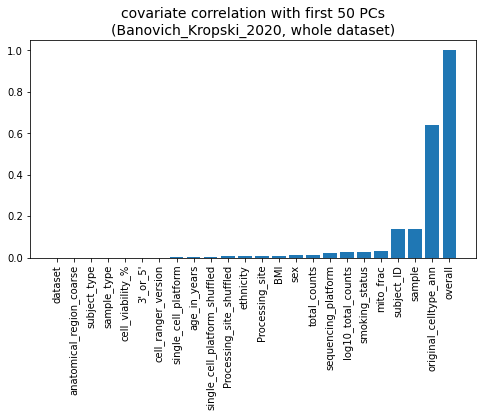

In [121]:
plt.figure(figsize=(8, 4))
plt.bar(
    total_variance_explained_clean[::-1].index,
    total_variance_explained_clean[::-1].values,
)
plt.title(
    f"covariate correlation with first 50 PCs\n({study_of_interest}, whole dataset)",
    fontsize=14,
)  # \n({dominant_type})
plt.xticks(rotation=90)
plt.show()

### Store results:

In [123]:
print("Study:", study_of_interest)

Study: Banovich_Kropski_2020


In [124]:
res = pd.DataFrame(total_variance_explained_clean)
res.columns = ["fraction_of_variance_explained"]
res.loc["single_cell_platform_shuffled", "stdev"] = stdev_single_cell_platform_shuffled
if include_processing_site:
    res.loc["Processing_site_shuffled", "stdev"] = stdev_processing_site_shuffled

In [125]:
res.to_csv(
    f"{dir_out}/{study_of_interest}_variance_explained_per_covariate.csv"
)

print z-score:

In [127]:
(
    res.loc["single_cell_platform", "fraction_of_variance_explained"]
    - res.loc["single_cell_platform_shuffled", "fraction_of_variance_explained"]
) / res.loc["single_cell_platform_shuffled", "stdev"]

-0.40137780967322567

In [130]:
if include_processing_site:
    print(
        (
            res.loc["Processing_site", "fraction_of_variance_explained"]
            - res.loc["Processing_site_shuffled", "fraction_of_variance_explained"]
        )
        / res.loc["Processing_site_shuffled", "stdev"]
    )

1.1970538520857914
